visited 26 from 41



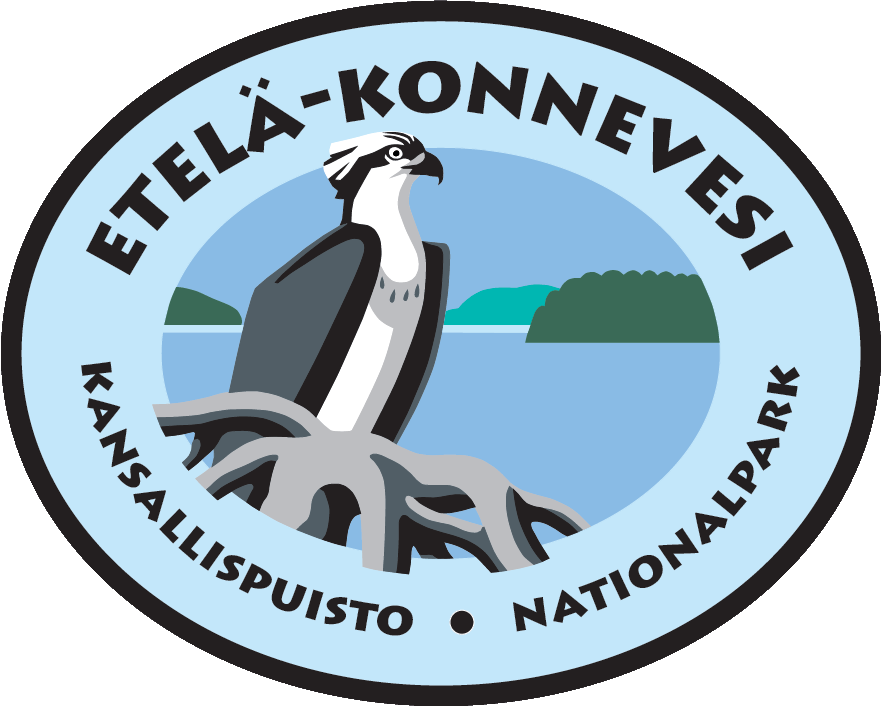
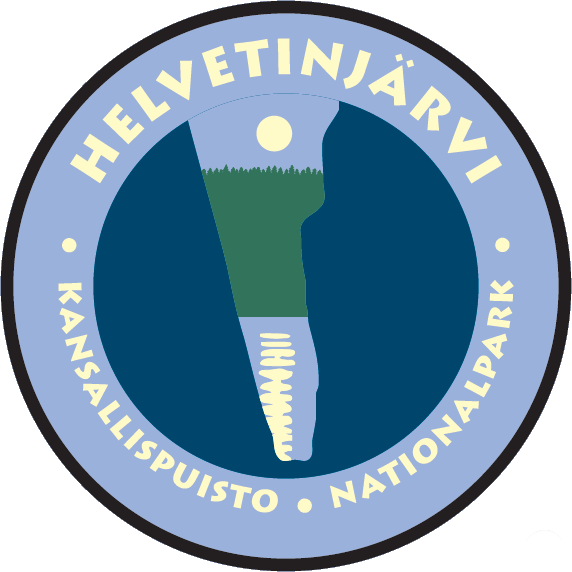
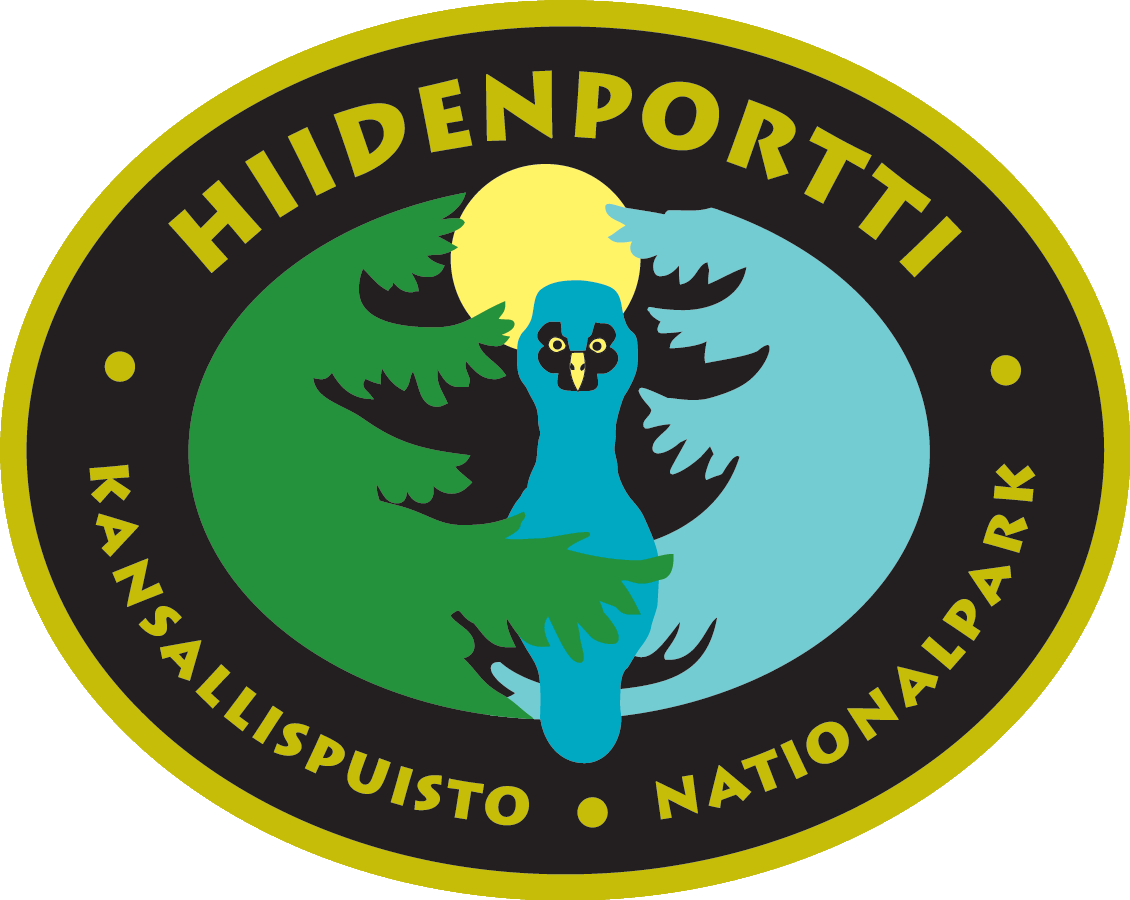
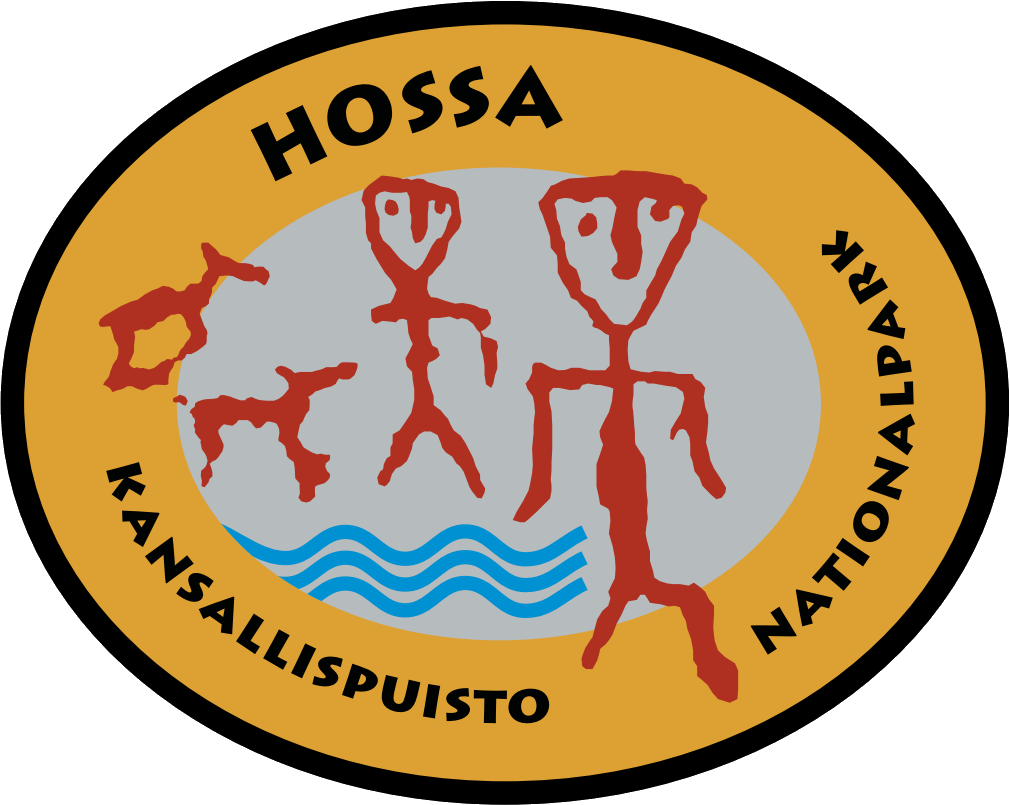
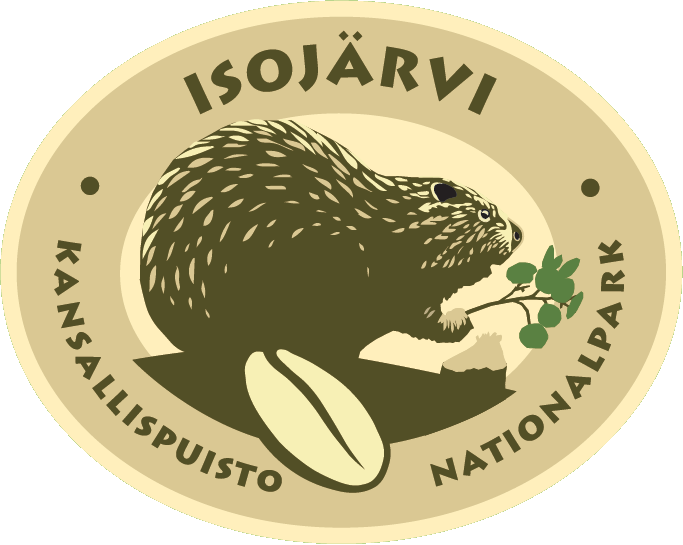
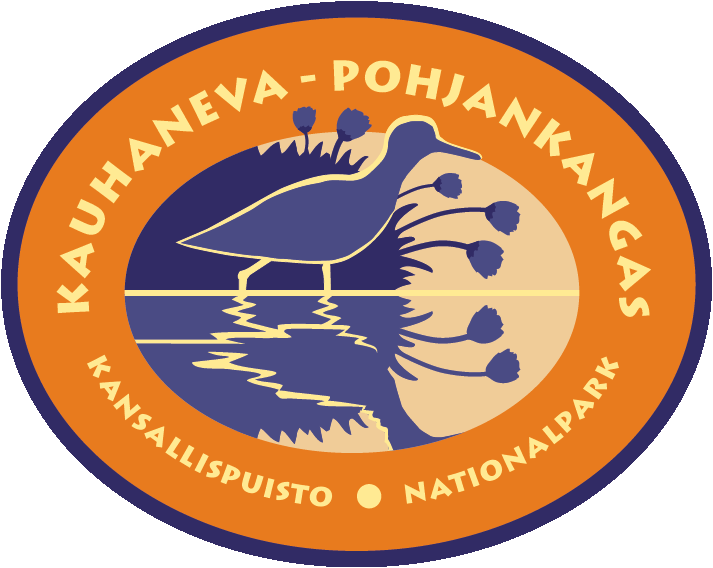
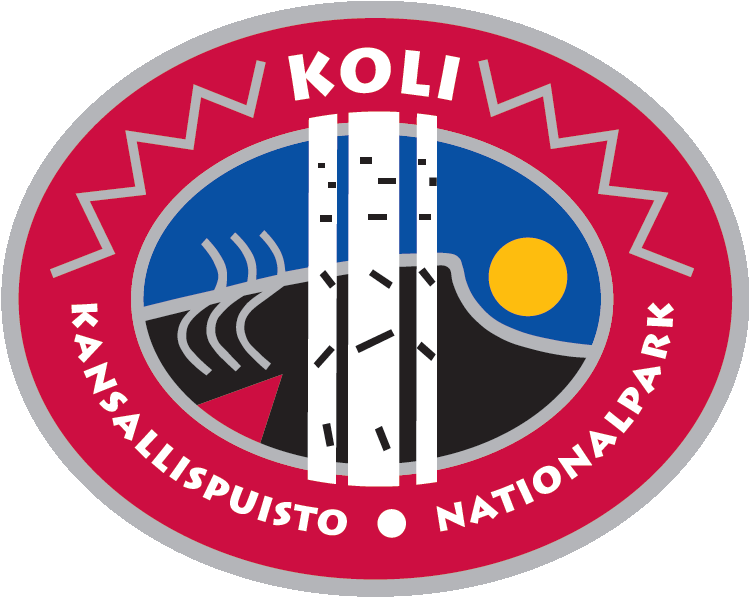
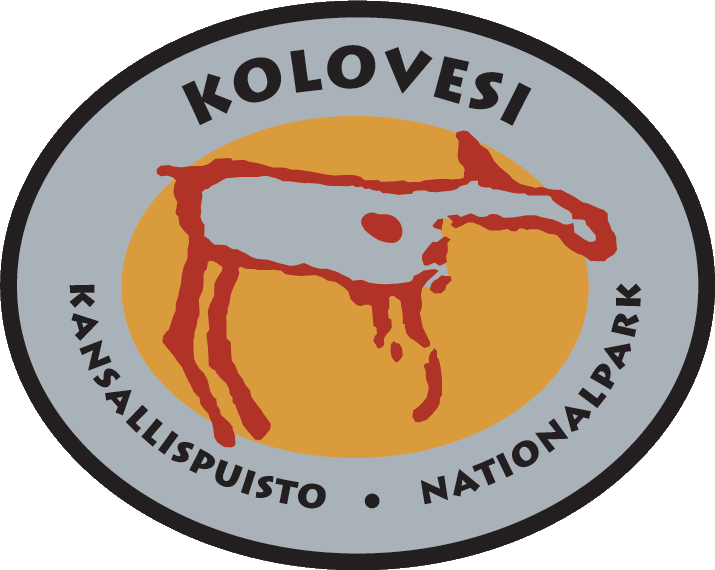
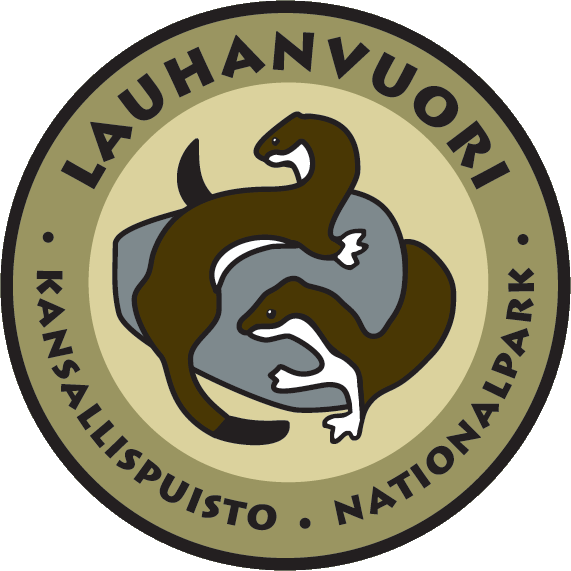
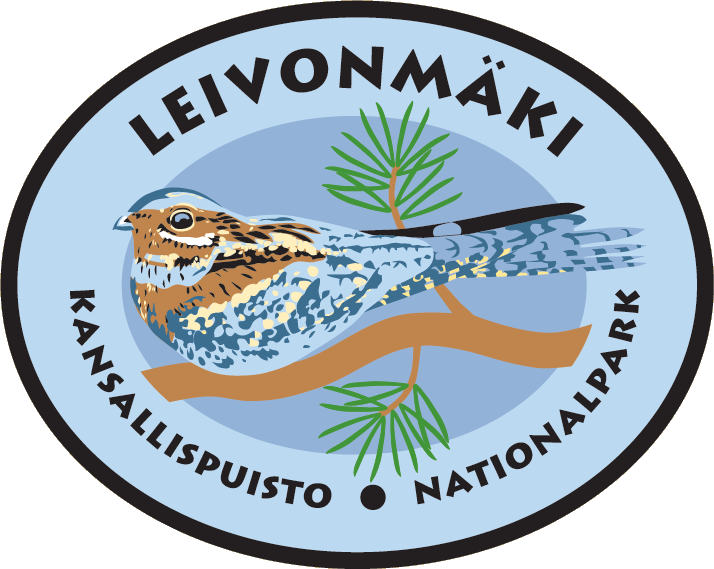
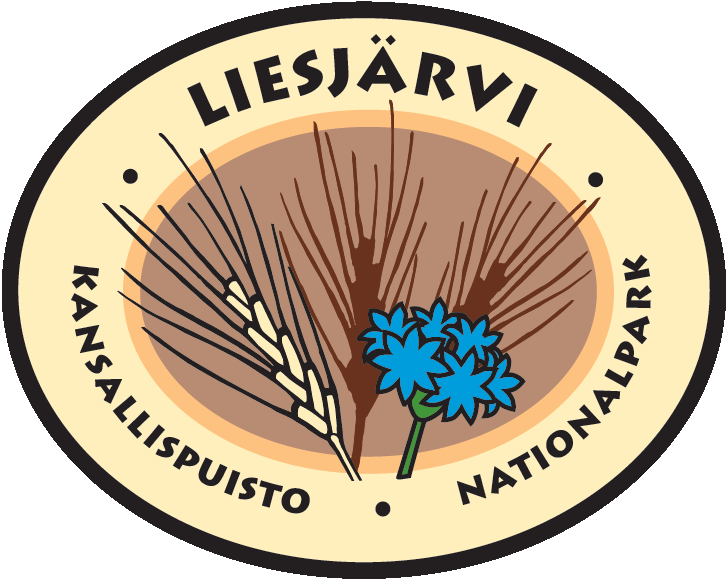
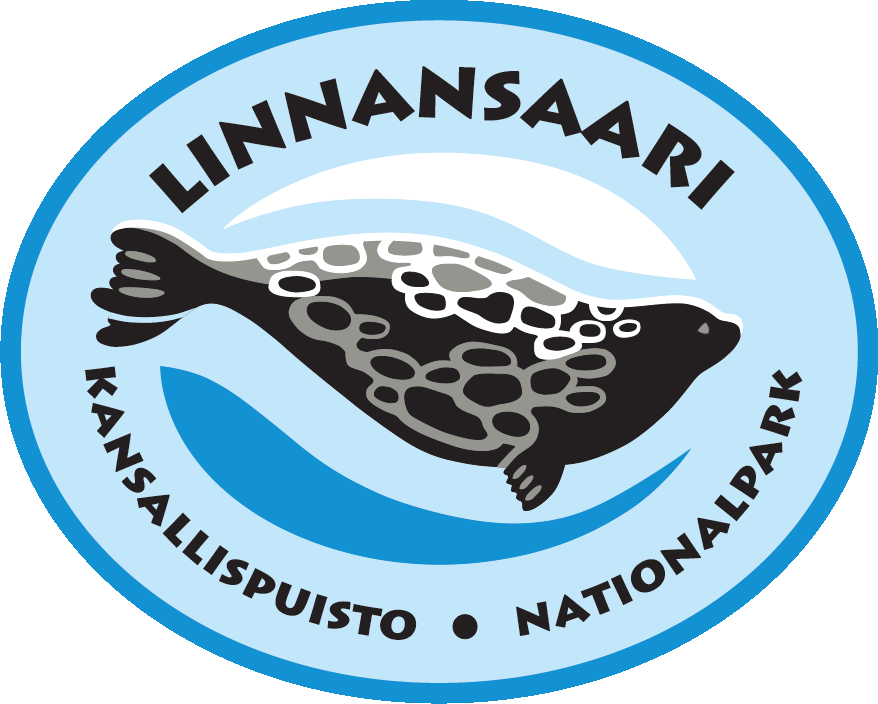
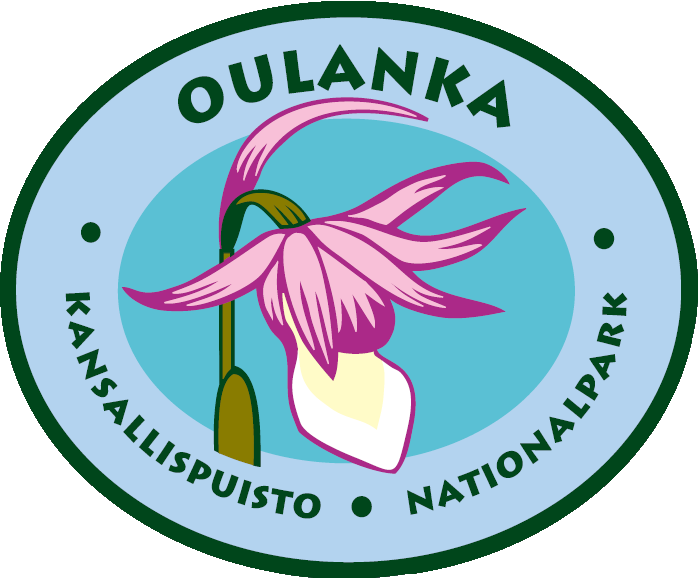
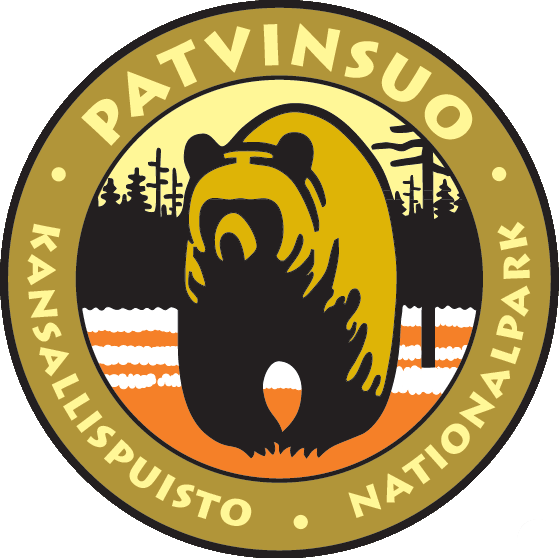
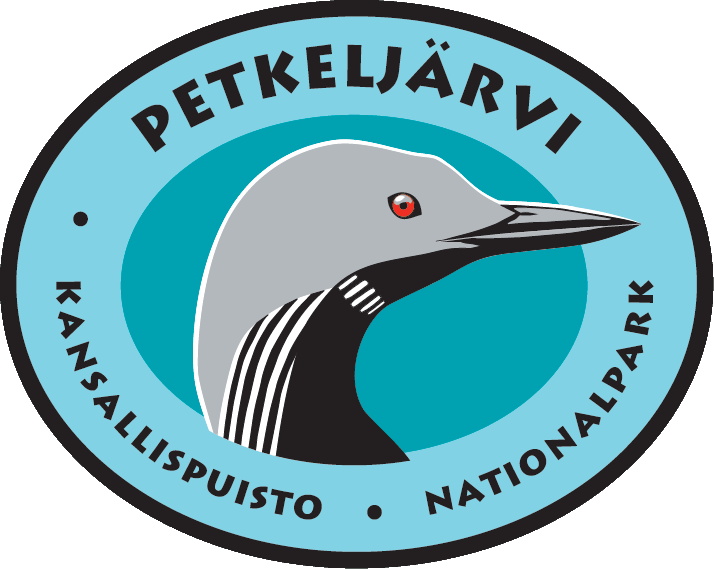
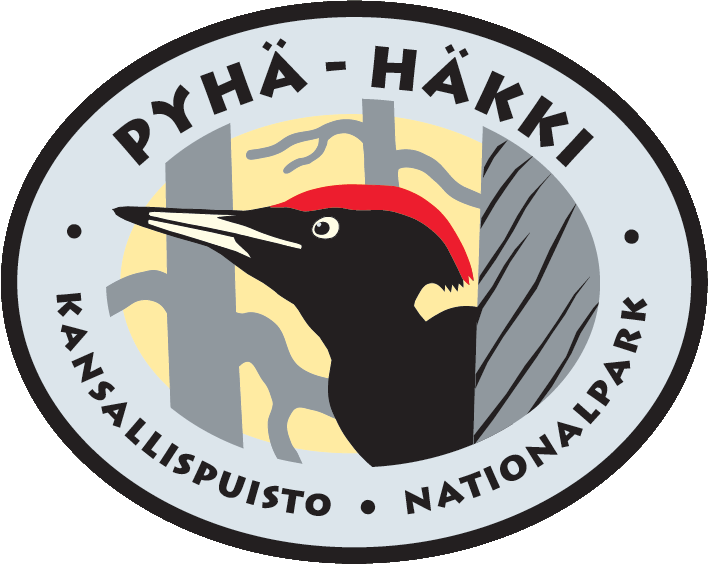
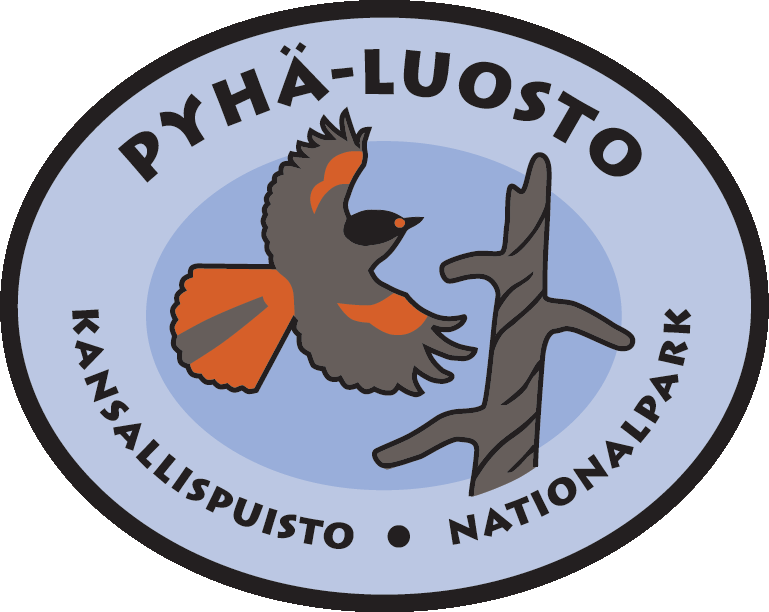
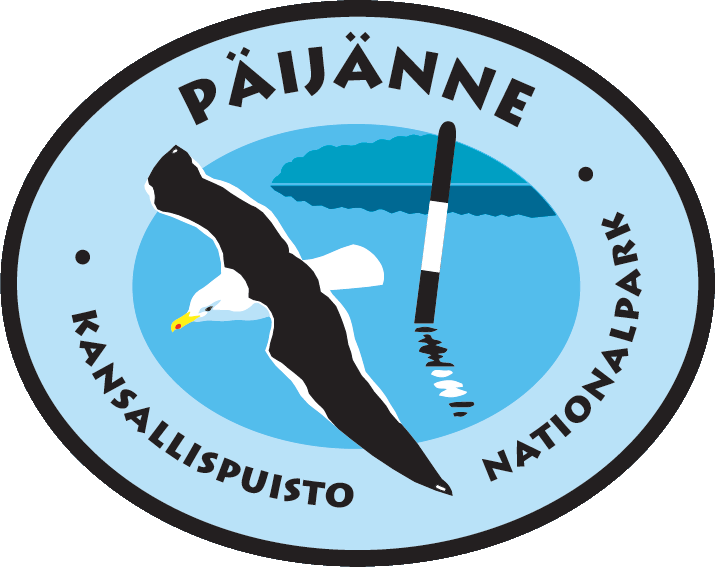
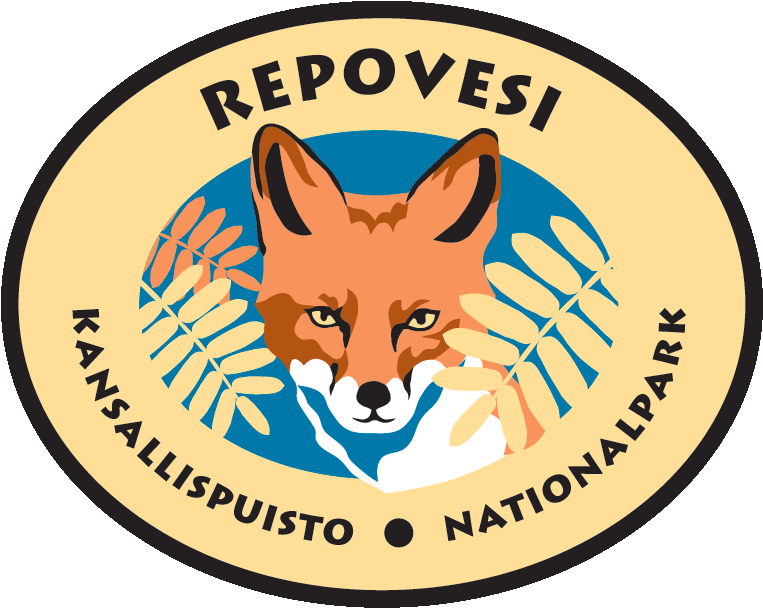
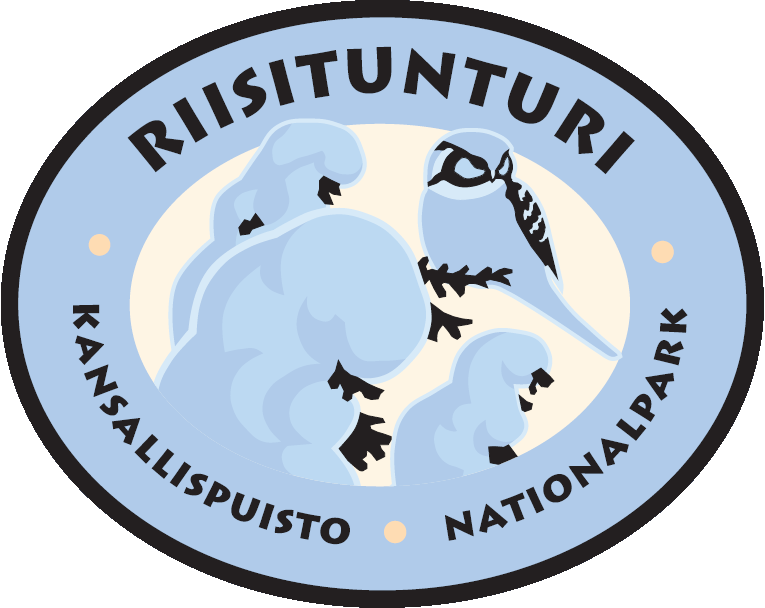
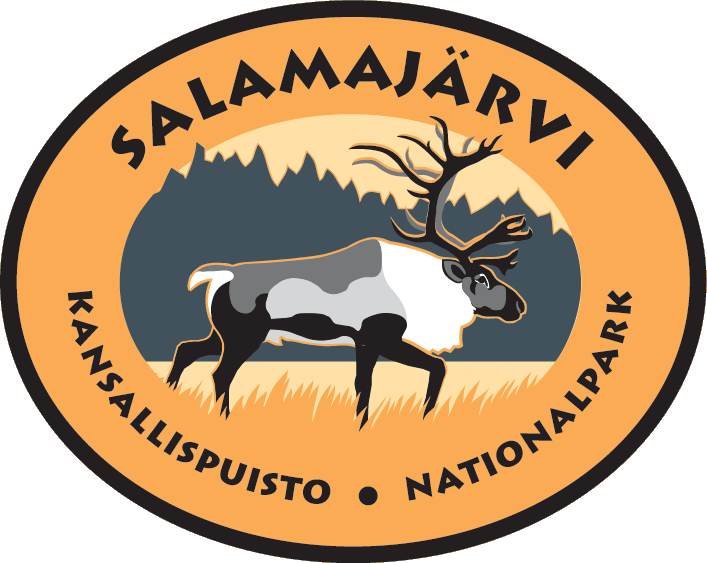
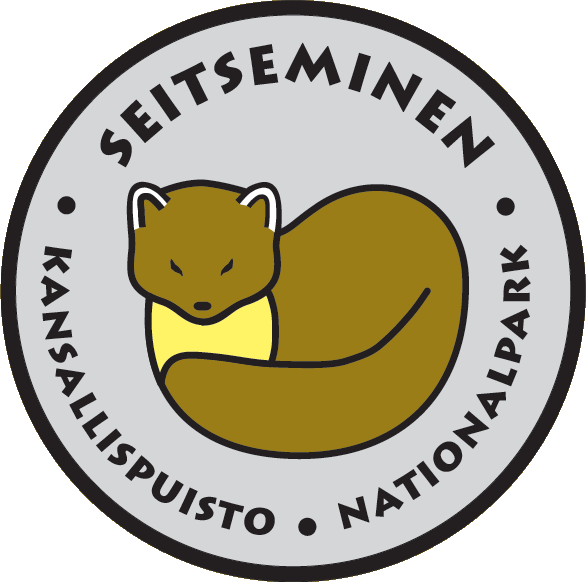
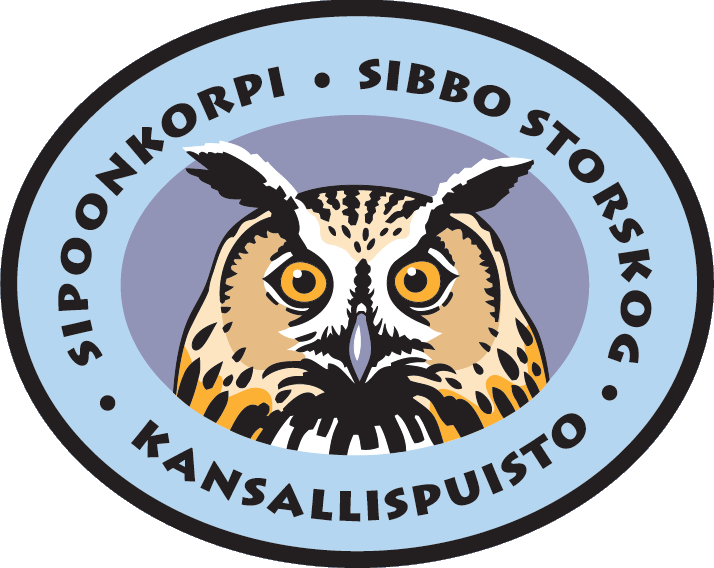
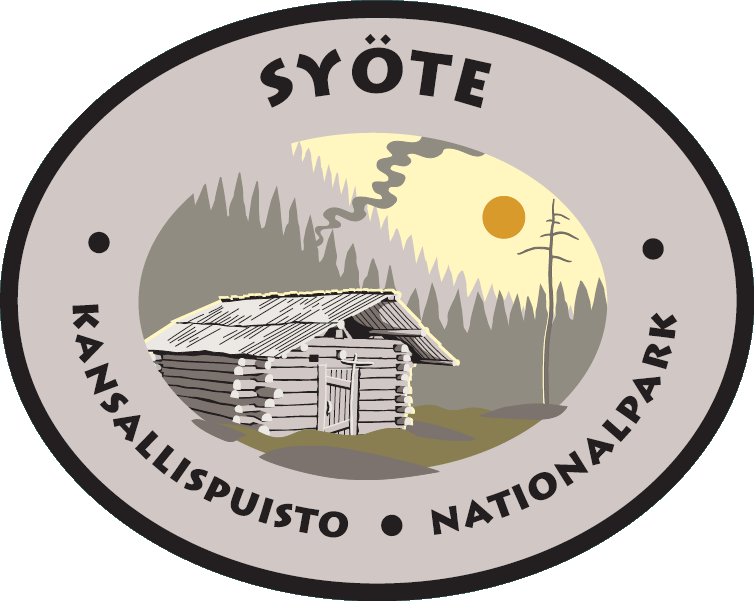
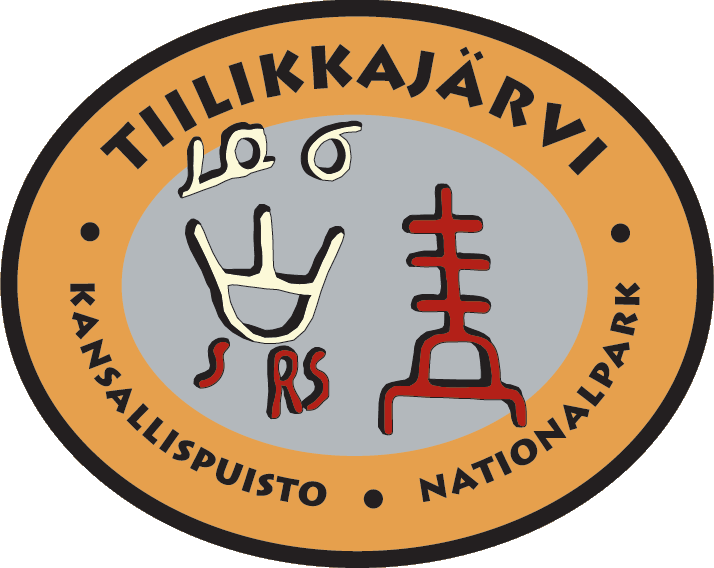
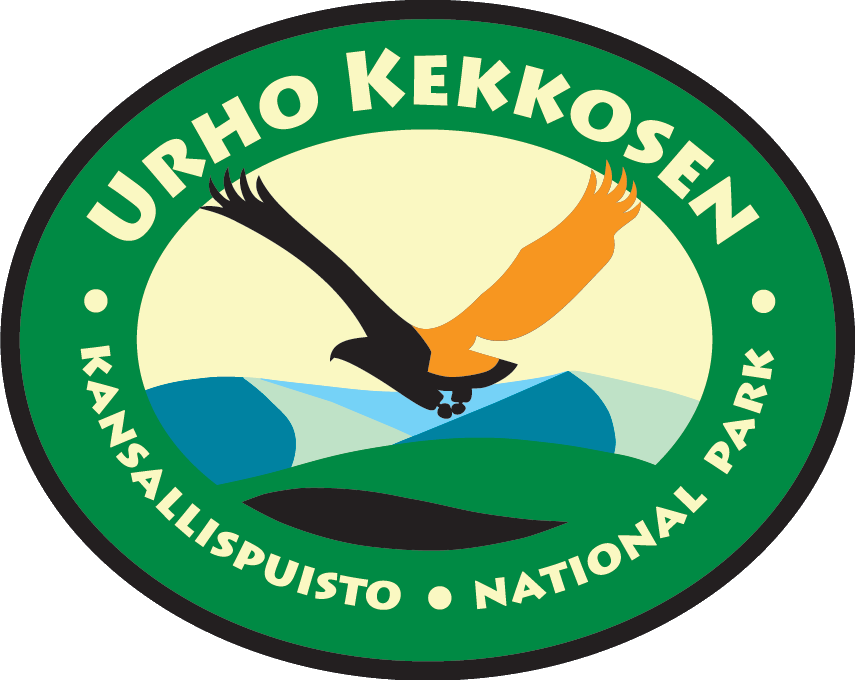

In [4]:
import pandas as pd
import folium

# Load the CSV file
file_path = "parks.csv"  # Replace with your actual file path
data = pd.read_csv(file_path, sep=";")
parks_in_total = data["Visited"].count()
parks_visited = data["Visited"].sum()
print('visited', parks_visited, 'from', parks_in_total)
# Create a map centered at an average location
center_lat = data["Latitude"].mean()
center_long = data["Longnitude"].mean()
map_national_parks = folium.Map(location=[center_lat, center_long], zoom_start=5)
icon_dict = {}
# Loop through the data and add markers
for _, row in data.iterrows():
    location = [row["Latitude"], row["Longnitude"]]
    icon_dict[row["National_park"]] = "park_icons/"+ row["National_park"] + ".png"
    if row["Visited"] == 1:
        icon = folium.CustomIcon(f"park_icons/{row['National_park']}.png", icon_size=(60,50))  # Visited icon
        # icon = folium.Icon(color="green", icon="check", prefix="fa")  # Visited icon
        popup = f"Visited: {row['Dates']}"
    else:
        icon = folium.Icon(color="red", icon="times", prefix="fa")  # Unvisited icon
        popup = "Not visited yet"
    
    folium.Marker(
        location=location,
        popup=f"{row['National_park']}<br>{popup}",
        icon=icon
    ).add_to(map_national_parks)

# Save the map to an HTML file
display(map_national_parks)

In [5]:
#display(data)
data['Dates'] = data['Dates'].str.split(',')
df_expanded = data.explode('Dates')
df_expanded['Dates'] = df_expanded['Dates'].str.strip()
df_expanded['Dates'] = pd.to_datetime(df_expanded['Dates'], format='%m/%y')
# Extract the year and month
df_expanded['year'] = df_expanded['Dates'].dt.year
df_expanded['month'] = df_expanded['Dates'].dt.month
df_expanded = df_expanded.drop(columns=['Dates'])
df_expanded = df_expanded.dropna(subset=['year'])
#display(df_expanded)

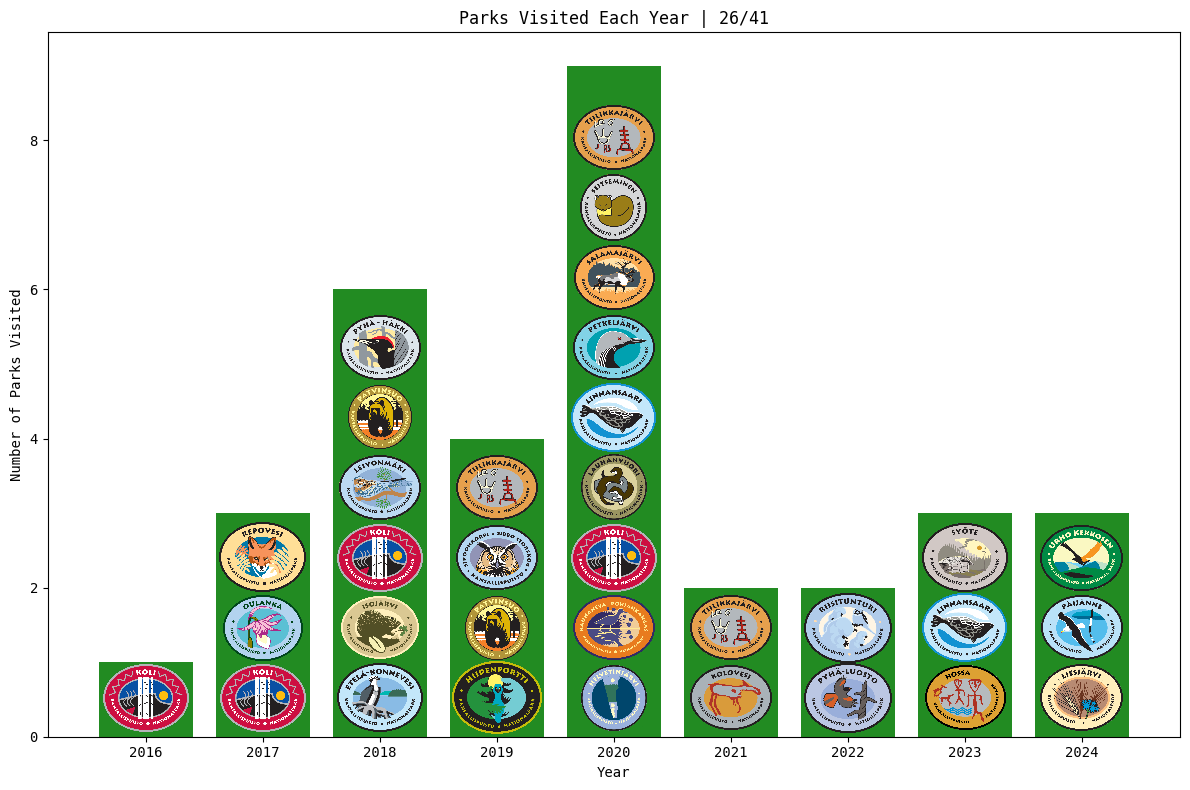

In [45]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image
import os
bar_color = "#228B22"

def add_white_background(image_path):
    img = Image.open(image_path).convert("RGBA")
    white_bg = Image.new("RGBA", img.size, bar_color)
    white_bg.paste(img, (0, 0), img)
    white_bg = white_bg.convert("RGB")
    return img

# Count the number of parks visited each year
year_counts = df_expanded.groupby('year')['National_park'].count()

# Create a bar plot
fig, ax = plt.subplots(figsize=(12, 8))
bars = ax.bar(year_counts.index, year_counts.values, color=bar_color)

# Add logos on top of each bar
for bar, year in zip(bars, year_counts.index):
    parks_in_year = df_expanded[df_expanded['year'] == year]['National_park'].unique()
    x = bar.get_x() + bar.get_width() / 2  # Center of the bar
    y = bar.get_height()  # Top of the bar
    
    for i, park_name in enumerate(parks_in_year):
        logo_path = icon_dict.get(park_name)
        if logo_path and os.path.exists(logo_path):
            # Load logo image
            #img = Image.open(logo_path)
            img = add_white_background(logo_path)
            imagebox = OffsetImage(img, zoom=0.082)  # Adjust zoom for size
            ab = AnnotationBbox(imagebox, (x, 0.52 + (i * 0.94)), frameon=False)  # Stack logos vertically
            ax.add_artist(ab)

# Set labels and title
ax.set_xlabel("Year")
ax.set_ylabel("Number of Parks Visited")
ax.set_title(f"Parks Visited Each Year | {parks_visited}/{parks_in_total}")
ax.set_xticks(year_counts.index)
plt.rcParams['font.family'] = 'monospace'
# Show plot
plt.tight_layout()
plt.show()

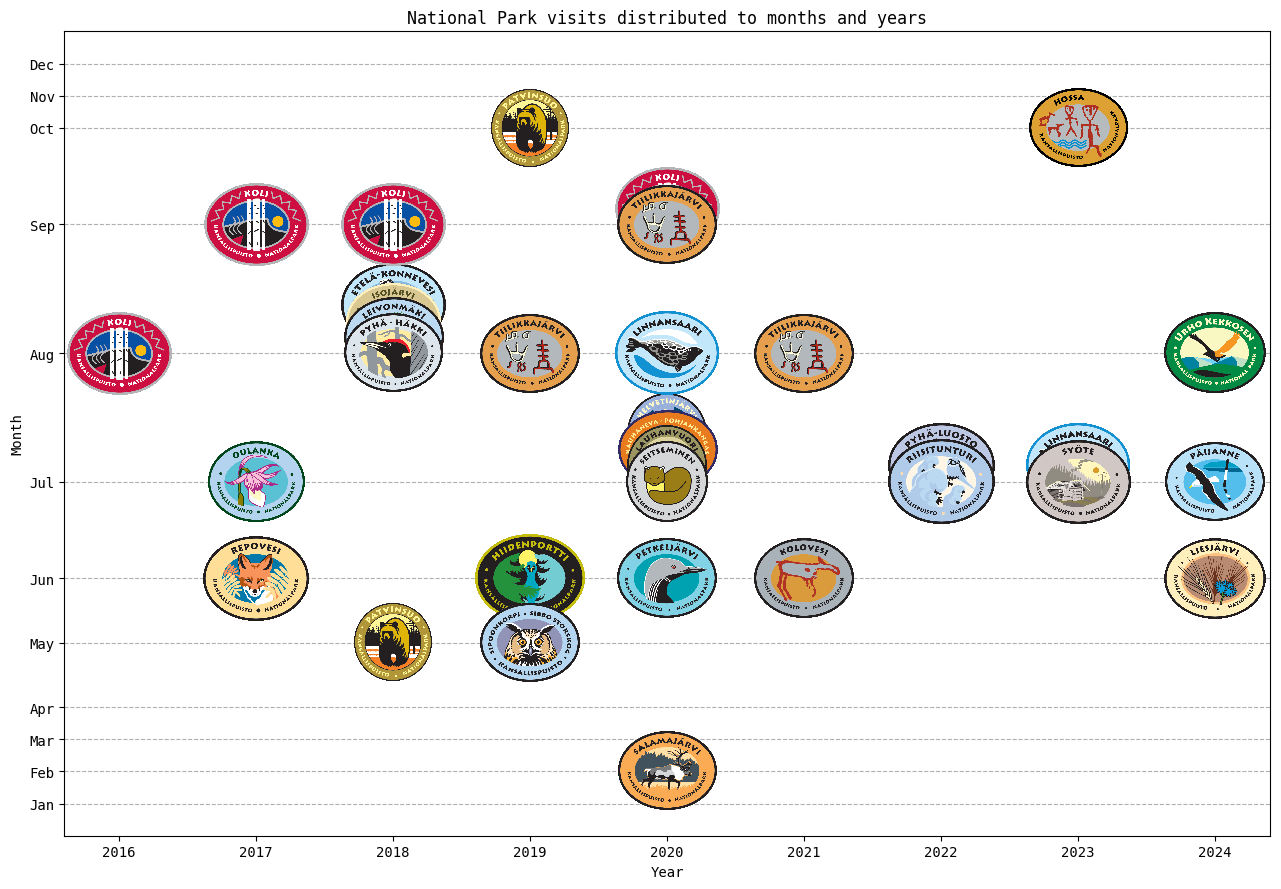

In [72]:
import matplotlib.image as mpimg

df_expanded['MonthlyVisits'] = df_expanded.groupby(['year', 'month'])['Visited'].transform('sum')
#display(df_expanded)

fig, ax = plt.subplots(figsize=(13, 9))

# Create scatter plot
scatter = ax.scatter(df_expanded['year'], df_expanded['month'], alpha=0)

# Set up the axes
ax.set_xlabel('Year')
ax.set_ylabel('Month')
ax.set_title('National Park visits distributed to months and years')
ax.grid(True, axis='y', linestyle='--')

# Adjust y-axis to show month names
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
y_positions = [3, 4, 5, 6, 8, 10, 13, 17, 21, 24, 25, 26] 
ax.set_yticks(y_positions)
ax.set_yticklabels(months)

# Add padding to the y-axis limits
ax.set_ylim(min(y_positions) - 1, max(y_positions) + 1)

month_to_ypos = dict(zip(range(1, 15), y_positions))

# Set x-axis to show only years
ax.set_xticks(df_expanded['year'].unique())

month_tracker_dict = {}

for index, row in df_expanded.iterrows():
    if row['Visited'] == 1:
        current_month = row['year'] * 1000 + row['month']
        if month_tracker_dict.get(current_month) == None:
            month_tracker_dict[current_month] = 1
        else:
            month_tracker_dict.update({current_month: month_tracker_dict[current_month] + 1})
        logo = mpimg.imread(f"park_icons/{row['National_park']}.png")
        imagebox = OffsetImage(logo, zoom=0.1)  # Adjust zoom as needed
        y_pos = month_to_ypos[row['month']]
        if row['MonthlyVisits'] > 1:
            ab = AnnotationBbox(imagebox, (row['year'], row['MonthlyVisits'] * 0.5 - month_tracker_dict[current_month] * 0.5 + y_pos ), frameon=False)
        else:
            ab = AnnotationBbox(imagebox, (row['year'], y_pos), frameon=False)
        ax.add_artist(ab)


plt.tight_layout()
plt.show()